In [1]:
import numpy as np
from bilby.core.prior import Prior

from matplotlib import pyplot as plt

### Customizing priors
Derive from `Prior`, and override `prob`, `ln_prob`, and `rescale`

Example, 
\begin{align}
p(x) =
    \begin{cases} 
        \frac{1}{2}\frac{e^x - e^{-a}}{1 - e^{-a}} & ; x \leq 0 \\
        \frac{1}{2} + \frac{1}{2}\frac{1 - e^{-x}}{1 - e^{-a}}& ; x > 0
    \end{cases} 
\end{align}

In [2]:
class MyAbsExponentialPrior(Prior):
    def __init__(self, *args, **kwargs):
        kwargs['maximum'] = 2
        kwargs['minimum'] = -kwargs['maximum']
        super().__init__(*args, **kwargs)

    def prob(self, val):
        _exp_minus_a = np.exp(-self.maximum)
        _norm = 2*(1 - _exp_minus_a)
        res = np.exp(-np.abs(val))/_norm
        if hasattr(val, 'size') and val.size > 1:  # is an array
            res[np.abs(val) > self.maximum] = 0.
        else:
            res = 0. if abs(val) > self.maximum else res
        return res

    def ln_prob(self, val):
        res = -np.abs(val)
        if hasattr(val, 'size') and val.size > 1:  # is an array
            res[np.abs(val) > self.maximum] = -np.inf
        else:
            res = -np.inf if abs(val) > self.maximum else res
        return res

    def rescale(self, val):
        self.test_valid_for_rescaling(val)
        neg_val_mask = val < 0.5
        pos_val_mask = val > 0.5
        _exp_minus_a = np.exp(-self.maximum)
        _norm = 2*(1 - _exp_minus_a)

        if not hasattr(val, 'size') or val.size==1:
            return np.log(_norm * val + _exp_minus_a) \
                if neg_val_mask else -np.log(1. - (val - 0.5)*_norm)

        neg_vals = val[neg_val_mask]
        pos_vals = val[pos_val_mask]

        res = np.empty(val.size)

        res[neg_val_mask] = np.log(_norm * neg_vals + _exp_minus_a)
        res[pos_val_mask] = -np.log(1. - (pos_vals - 0.5)*_norm)
        return res

Text(0.5, 0, 'x')

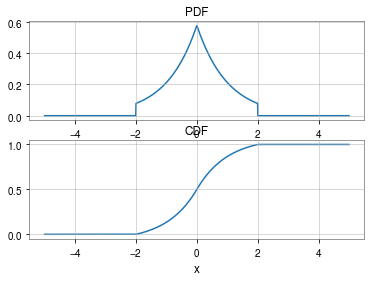

In [3]:
my_prior_instance = MyAbsExponentialPrior()

fig, (ax1, ax2) = plt.subplots(2, 1)
x = np.linspace(-5, 5, 1000)
y = my_prior_instance.prob(x)
Y = my_prior_instance.cdf(x)
ax1.plot(x, y)
ax1.set_title("PDF")
ax2.plot(x, Y)
ax2.set_title("CDF")
ax2.set_xlabel("x")

Text(0.5, 0, 'x')

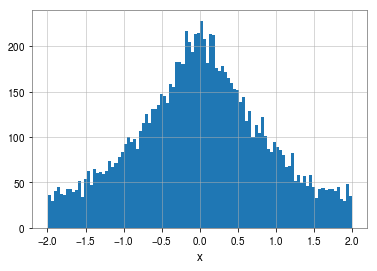

In [4]:
samples = my_prior_instance.sample(10000)
plt.hist(samples, bins=100)
plt.xlabel('x')

### Another example

Prior on redshift for $z \ll 1$

\begin{align}
    p(z) \propto z^2
\end{align}



In [5]:
class ZSquaredPrior(Prior):
    def prob(self, z):
        norm = (1./3.) * (self.maximum**3 - self.minimum**3)
        res = z**2 / norm
        if not hasattr(z, 'size') or z.size==1:
            return res if self.minimum <= z <= self.maximum else 0.
        res[z <= self.minimum] = 0.
        res[z >= self.maximum] = 0.
        return res
    
    def rescale(self, p):
        self.test_valid_for_rescaling(p)
        norm = self.maximum**3 - self.minimum**3
        res = np.cbrt(p * norm + self.minimum**3)
        return res

Text(0.5, 0, 'z')

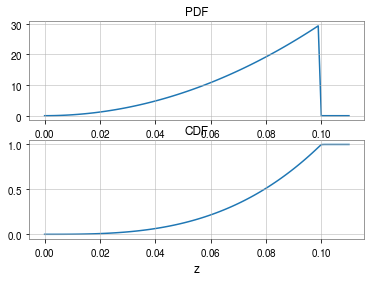

In [6]:
z_squared_prior = ZSquaredPrior(minimum=1e-3, maximum=0.1)

fig, (ax1, ax2) = plt.subplots(2, 1)
x = np.linspace(0, 0.11, 100)
y = z_squared_prior.prob(x)
Y = z_squared_prior.cdf(x)
ax1.plot(x, y)
ax1.set_title("PDF")
ax2.plot(x, Y)
ax2.set_title("CDF")
ax2.set_xlabel("z")

Text(0.5, 0, 'Redshift Prior')

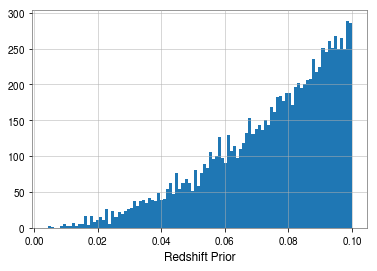

In [7]:
z_vals = z_squared_prior.sample(10000)
plt.hist(z_vals, bins=100)
plt.xlabel('Redshift Prior')

### Customizing likelihoods
Base class `Likelihood`; 1D continuous case `Analytical1DLikelihood`

\begin{align}
y = f(x) + n
\end{align}

- Some $\{y_i, x_i\}$ is present
- $f$ is the model `func`
- $p(n)$ determines the likelihood function

Example, say $p(n) \sim e^{\vert n \vert}$:
\begin{align}
    \mathcal{L}({y_i, x_i}\vert f) = \frac{1}{2}\exp\left(\vert y_i - x_i \vert\right)
\end{align}

In [8]:
import bilby
from bilby.core.likelihood import Analytical1DLikelihood
from bilby.core.prior import DeltaFunction
from scipy.special import gamma

In [9]:
class MyExpLikelihood(Analytical1DLikelihood):
    def log_likelihood(self):
        log_l = np.sum(- (self.residual) - np.log(2))
        return log_l

In [10]:
def students_t_pdf(x, nu=1, mu=1, sig=1):
    w = (x-mu)/sig
    r = 1 + w**2/nu
    r = np.power(r, -0.5*(nu+1))
    r *= gamma(0.5*(nu + 1))/gamma(0.5*nu)
    r /= sig*np.sqrt(np.pi * nu)
    return r

In [11]:
injection_parameters = dict(nu=1, mu=1, sig=1)
x = np.linspace(-4, 4, 100)
data = students_t_pdf(x, **injection_parameters) + np.random.normal(0, 0.1, x.size)

Text(0, 0.5, 'y')

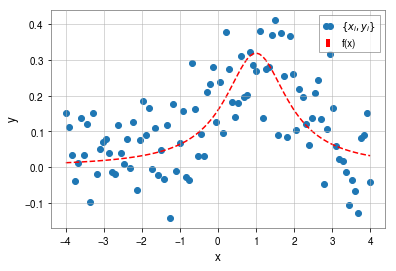

In [12]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\{x_i, y_i\}$')
ax.plot(x, students_t_pdf(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [13]:
log_l = MyExpLikelihood(x, data, students_t_pdf)

In [14]:
priors = dict()
priors['mu'] = MyAbsExponentialPrior(name='mu', latex_label='m')
priors['nu'] = DeltaFunction(3.0, name='nu', latex_label='n')
priors['sig'] = DeltaFunction(1.0, name='sig', latex_label='s')

In [15]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    npoints=100, walks=100, npool=4, injection_parameters=injection_parameters,
    outdir='./hopeless_student_t',
    label='hopeless_student_t'
)

17:39 bilby INFO    : Running for label 'hopeless_student_t', output will be saved to './hopeless_student_t'
17:39 bilby INFO    : Search parameters:
17:39 bilby INFO    :   mu = MyAbsExponentialPrior()
17:39 bilby INFO    :   nu = 3.0
17:39 bilby INFO    :   sig = 1.0
17:39 bilby INFO    : Single likelihood evaluation took 1.514e-04 s


0it [00:00, ?it/s]

17:39 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f9723226240>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
17:39 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:39 bilby INFO    : Using dynesty version 1.0.1
17:39 bilby INFO    : Generating initial points from the prio

245it [00:00, 2314.06it/s, bound:0 nc:  1 ncall:1.2e+03 eff:20.0% logz=-67.89+/-0.05 dlogz:0.099>0.1]

17:39 bilby INFO    : Written checkpoint file ./hopeless_student_t/hopeless_student_t_resume.pickle
17:39 bilby INFO    : Writing 123 current samples to ./hopeless_student_t/hopeless_student_t_samples.dat
17:39 bilby INFO    : Starting to close worker pool.
17:39 bilby INFO    : Finished closing worker pool.
17:39 bilby INFO    : Sampling time: 0:00:00.278302
17:39 bilby INFO    : Summary of results:
nsamples: 345
ln_noise_evidence:    nan
ln_evidence: -67.795 +/-    nan
ln_bayes_factor:    nan +/-    nan



In [16]:
result.posterior.head()

,mu,nu,sig,log_likelihood,log_prior
0,-1.993189,3.0,1.0,-68.254669,-1.993189
1,1.970888,3.0,1.0,-68.237836,-1.970888
2,1.970888,3.0,1.0,-68.237836,-1.970888
3,-1.901443,3.0,1.0,-68.188211,-1.901443
4,-1.901443,3.0,1.0,-68.188211,-1.901443


Text(0.5, 0, 'mu')

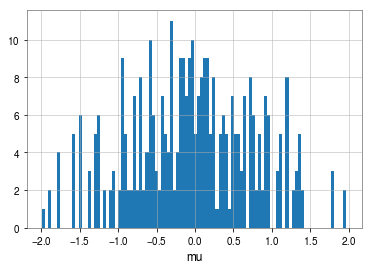

In [17]:
result.posterior.mu.hist(bins=100)
plt.xlabel('mu')